In [76]:
# Import packages 
import warnings
warnings.simplefilter("ignore")

# Plotting 
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from plotnine import * 
import plotnine 


import pandas as pd
import numpy as np 
from pandas.plotting import autocorrelation_plot
import statsmodels.tsa.stattools as sts 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [67]:
z = pd.read_csv("./DATA/z_file.csv")
z = z[8:] # Removing minting days 

<h3> White Noise?

If your data is "white noise", we cannot conduct a time series analysis. Three conditions must be met for this to occur: 
1.) The average value (mean) is zero
2.) Standard deviation is constant — it doesn’t change over time
3.) The correlation between time series and its lagged version is not significant

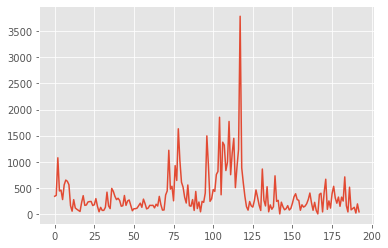

In [101]:
# Plot data 
plt.plot(np.arange(len(z['Normal_value_normalized'])), z['Normal_value_normalized'])

We can see from the plot above, that our data has a moving average, so we should be able to perform a time-series analysis with this dataset. 

<h3> Stationarity

Stationarity: observations do not depend on time<br> 
Taking consecutive samples of data with the same size should have identical covariances regardless of the starting point (weak form)  <br>
Samples of identical size have identical distributions (strict form) <br>
1.) Constant mean <br>
2.) Constant variance <br>
3.) Constant covariance between periods of identical distance: covariance between time periods of identical lengths (let’s say 10 days/hours/minutes) should be identical to the covariance of some other period of the same length

Null Hypothesis: Time series is not stationary <br>
Alternative Hypothesis: Time series is stationary

In [68]:
# Calculate Augmented Dicky Fuller test
sts.adfuller(z['Normal_value_normalized'])

(-2.5123313129068987,
 0.11250273992575116,
 6,
 187,
 {'1%': -3.465811691080702,
  '5%': -2.877123351472649,
  '10%': -2.5750770662586864},
 2614.23865154505)

Our p-value is approximately 0.113 which is not statistically significant. Hence, our data is not stationary, and we must differentiate the series (subtract current value from previous instance)  

<h4> Calculate First Order Difference

In [69]:
# Calculate first order difference 
z['Normal_value_normalized_diff'] = z['Normal_value_normalized'].diff(periods=1)
z = z.dropna()

In [135]:
# Calculate Augmented Dicky Fuller test for differentiated data 
sts.adfuller(z['Normal_value_normalized_diff'])

(-9.192197639538946,
 2.108592888523473e-15,
 5,
 187,
 {'1%': -3.465811691080702,
  '5%': -2.877123351472649,
  '10%': -2.5750770662586864},
 2604.4768010478224)

With a differentiation order of 1, our series is now stationary indicated by our p-value (0.00). One thing to note is that we can continue to increase the differentiation order until we have a satisfactory p-value. 

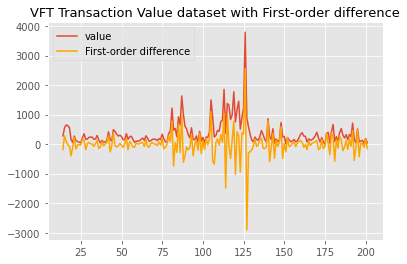

In [51]:
plt.title('VFT Transaction Value dataset with First-order difference', size=13)
plt.plot(z['Normal_value_normalized'], label='value')
plt.plot(z['Normal_value_normalized_diff'], label='First-order difference', color='orange')
plt.legend()

<h3> Calculate autocorrelation

In [71]:
acf_values = acf(z['Normal_value_normalized_diff'])
np.round(acf_values,2)

array([ 1.  , -0.42, -0.02, -0.06,  0.05, -0.1 ,  0.03,  0.11, -0.03,
       -0.11,  0.08,  0.07, -0.21,  0.16, -0.01,  0.01, -0.08,  0.08,
       -0.06, -0.04, -0.02,  0.11, -0.01])

Autocorrelation: a correlation between a sequence with itself lagged by some number of time units. 
The y-axis on the autocorrelation plot is the correlation value, and the x-axis is the lag time. Essentially each point is determining the correlation of x(t) - x(t-1). The plot below indicates that a lag time of 1 and 2 has very high autocorrelation values, and these correlations are statistically significant (anything outside of the shaded area). This tells you the value prior and the value two prior values ago heavily impacts the current value. With that being said, we would anticipate high correlation in earlier lag times and for this correlation to decrease as the lag time increased. 

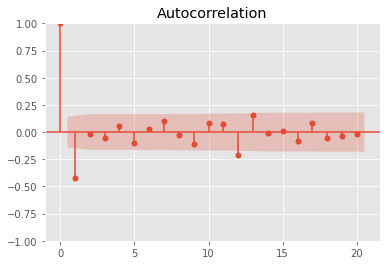

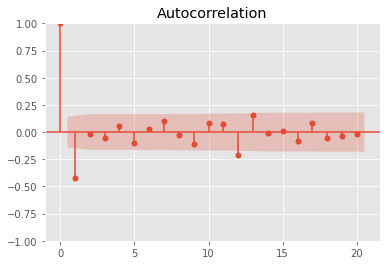

In [72]:
plot_acf(z['Normal_value_normalized_diff'], lags=20)

Partial autocorrelation: shows only the direct effect of each prior value and all intermediary effects are removed. The value from 12 days ago affects the value 11 months ago, and this effect continues until the current period. These indirect effects are neglected in partial autocorrelation calculations.

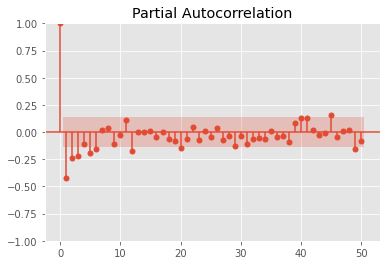

In [74]:
plot_pacf(z['Normal_value_normalized_diff'], lags=50)
pyplot.show()

Given our autocorrelation and partial autocorrelation plots, I believe we will not have a very strong ARIMA model. Our data appears to have week autocorrelations (random walk), so in other words, our values seem to be dependent on chance rather than prior values. However, we will still conduct the ARIMA model to confirm that this is the case.

In [109]:
# Specify model 
p,d,q = 5,1,0
# p:lag order 
# d: hyperparameter (difference between obs)
# q: hyperparameter (time window for MA's residual error)
model = ARIMA(z['Normal_value_normalized_diff'], order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:     Normal_value_normalized_diff   No. Observations:                  193
Model:                           ARIMA(5, 1, 0)   Log Likelihood               -1439.120
Date:                          Fri, 03 Dec 2021   AIC                           2890.240
Time:                                  10:24:46   BIC                           2909.785
Sample:                                       0   HQIC                          2898.156
                                          - 193                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2427      0.035    -35.378      0.000      -1.312      -1.174
ar.L2         -1.1484      0.054    -21.100      0.

Our AIC or Akaike information criterion is quite high, indicating that our model does not have a great fit.

In [116]:
data = z['Normal_value_normalized'].values

In [117]:
train_size = int(len(data) * 0.66)
train, test = data[0:train_size], data[train_size:len(data)]

In [118]:
history = [x for x in train]
predictions = list()

In [119]:
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,5))
    model_fit = model.fit()
    pred = model_fit.forecast()
    yhat = pred[0]
    predictions.append(yhat)
    # Append test observation into overall record
    obs = test[t]
    history.append(obs)


In [120]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 215.983


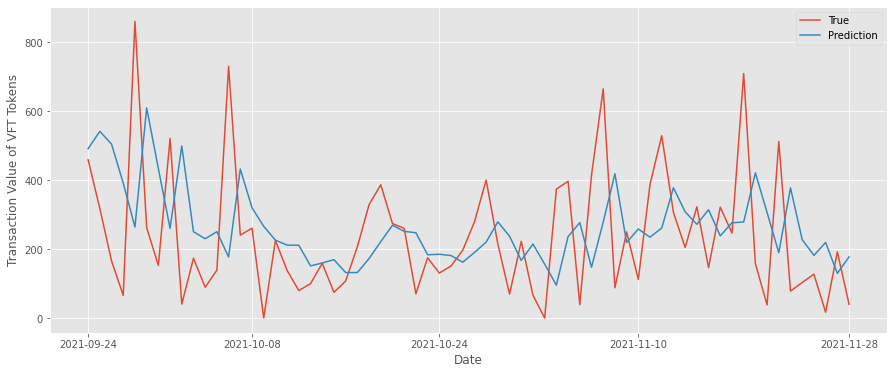

In [134]:
h = z[127:]
se = pd.Series(predictions)
h['predictions'] = se.values

# Plot 2021 number of transactions 
fig, ax = plt.subplots(figsize =(15, 6))

plt.plot(h['year_month'], h['Normal_value_normalized'], label="True")
plt.plot(h['year_month'], h['predictions'], label="Prediction")

# Specify Title
plt.title("", size=15, y =1)

# Labeling 
plt.xlabel("Date", size=12)
plt.ylabel("Transaction Value of VFT Tokens", size=12)
plt.legend()
plt.xticks(['2021-09-24', '2021-10-08', '2021-10-24', '2021-11-10','2021-11-28'])

# Remove output text 
for txt in ax.texts:
    txt.set_visible(False)

As can be seen our model does a poor job of predicting VeeFriend transaction prices. As the project is only seven months, it may be possible that our model could improve with additional data. It would be interesting to conduct an analysis on an older project (e.g., Cryptopunk or CryptoKitties) to test this hypothesis. It may be the case, however, that token transaction values are dependent on random outside variables (e.g., celebrity support). 